<a href="https://colab.research.google.com/github/Suhit97/Quora-Question-Similarity/blob/master/Quora_Dup_Question_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from os.path import expanduser, exists
import json, datetime, time

from sklearn.model_selection import train_test_split

In [ ]:
DATASETS_DIR = "/content/gdrive/My Drive/quora_dup/"


Q1_TRAINING_DATA_FILE = DATASETS_DIR + 'q1_train.npy'
Q2_TRAINING_DATA_FILE = DATASETS_DIR + 'q2_train.npy'
LABEL_TRAINING_DATA_FILE = DATASETS_DIR + 'label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = DATASETS_DIR + 'word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = DATASETS_DIR + 'nb_words.json'


MAX_NB_WORDS = 200000
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300
MODEL_WEIGHTS_FILE = 'question_pairs_weights.h5'
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
RNG_SEED = 1997
NB_EPOCHS = 25
DROPOUT = 0.1
BATCH_SIZE = 32
OPTIMIZER = 'adam'

In [ ]:
if exists(Q1_TRAINING_DATA_FILE) and exists(Q2_TRAINING_DATA_FILE) and exists(LABEL_TRAINING_DATA_FILE) and exists(NB_WORDS_DATA_FILE) and exists(WORD_EMBEDDING_MATRIX_FILE):
    # Then load them
    q1_data = np.load(open(Q1_TRAINING_DATA_FILE, 'rb'))
    q2_data = np.load(open(Q2_TRAINING_DATA_FILE, 'rb'))
    labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))
    word_embedding_matrix = np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))
    with open(NB_WORDS_DATA_FILE, 'r') as f:
        nb_words = json.load(f)['nb_words']

else:
  print("error loading file")

In [ ]:
# Partition the dataset into train and test sets
X = np.stack((q1_data, q2_data), axis=1)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RNG_SEED)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

In [ ]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, Dense, Lambda, concatenate, Dropout, BatchNormalization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras import backend as K

In [ ]:
# Define the model
question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

In [ ]:
q1 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question1)
q1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q1)
q1 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q1)

q2 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question2)
q2 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q2)
q2 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q2)

merged = concatenate([q1,q2])
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

is_duplicate = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=is_duplicate)
model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])


In [ ]:
# Train the model, checkpointing weights with best validation accuracy
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True)]
history = model.fit([Q1_train, Q2_train],
                    y_train,
                    epochs=NB_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    verbose=2,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)



Starting training at 2020-08-14 09:39:39.983185
Epoch 1/25
10234/10234 - 90s - loss: 0.5376 - accuracy: 0.7288 - val_loss: 0.4850 - val_accuracy: 0.7610
Epoch 2/25
10234/10234 - 88s - loss: 0.4872 - accuracy: 0.7612 - val_loss: 0.4672 - val_accuracy: 0.7760
Epoch 3/25
10234/10234 - 88s - loss: 0.4596 - accuracy: 0.7781 - val_loss: 0.4589 - val_accuracy: 0.7713
Epoch 4/25
10234/10234 - 88s - loss: 0.4379 - accuracy: 0.7910 - val_loss: 0.4304 - val_accuracy: 0.7924
Epoch 5/25
10234/10234 - 89s - loss: 0.4182 - accuracy: 0.8028 - val_loss: 0.4231 - val_accuracy: 0.7968
Epoch 6/25
10234/10234 - 88s - loss: 0.4036 - accuracy: 0.8130 - val_loss: 0.4211 - val_accuracy: 0.7985
Epoch 7/25
10234/10234 - 88s - loss: 0.3877 - accuracy: 0.8220 - val_loss: 0.4163 - val_accuracy: 0.8028
Epoch 8/25
10234/10234 - 89s - loss: 0.3753 - accuracy: 0.8294 - val_loss: 0.4065 - val_accuracy: 0.8044
Epoch 9/25
10234/10234 - 87s - loss: 0.3635 - accuracy: 0.8360 - val_loss: 0.4025 - val_accuracy: 0.8099
Epoch 1

<Figure size 432x288 with 0 Axes>

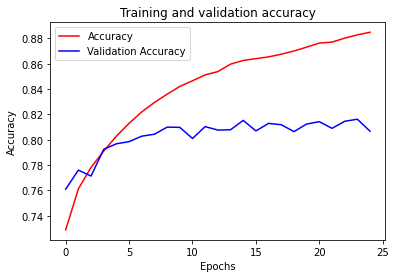

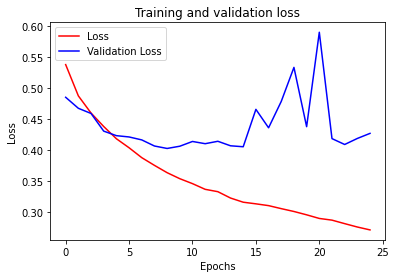

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()